In [39]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import nibabel as nib
import numpy.ma as ma
from numpy import savetxt
import os
import brainstat.mesh.data as mesh
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data

#input variables and path defs
workDir = '/host/percy/local_raid/hans/amyg/func/'
outDir = str(workDir+'outputs/')
volDir = '/data_/mica3/BIDS_PNC/rawdata/'
regDir = '/data_/mica1/03_projects/hans/7T/registration/'
outDir1 = '/host/percy/local_raid/hans/amyg/func/'


(64984,)
[7 2 2 ... 7 7 6]
(7, 64984)
[[nan nan nan ... nan nan nan]
 [nan  2.  2. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan  6.]
 [ 7. nan nan ...  7.  7. nan]]
(7, 3)


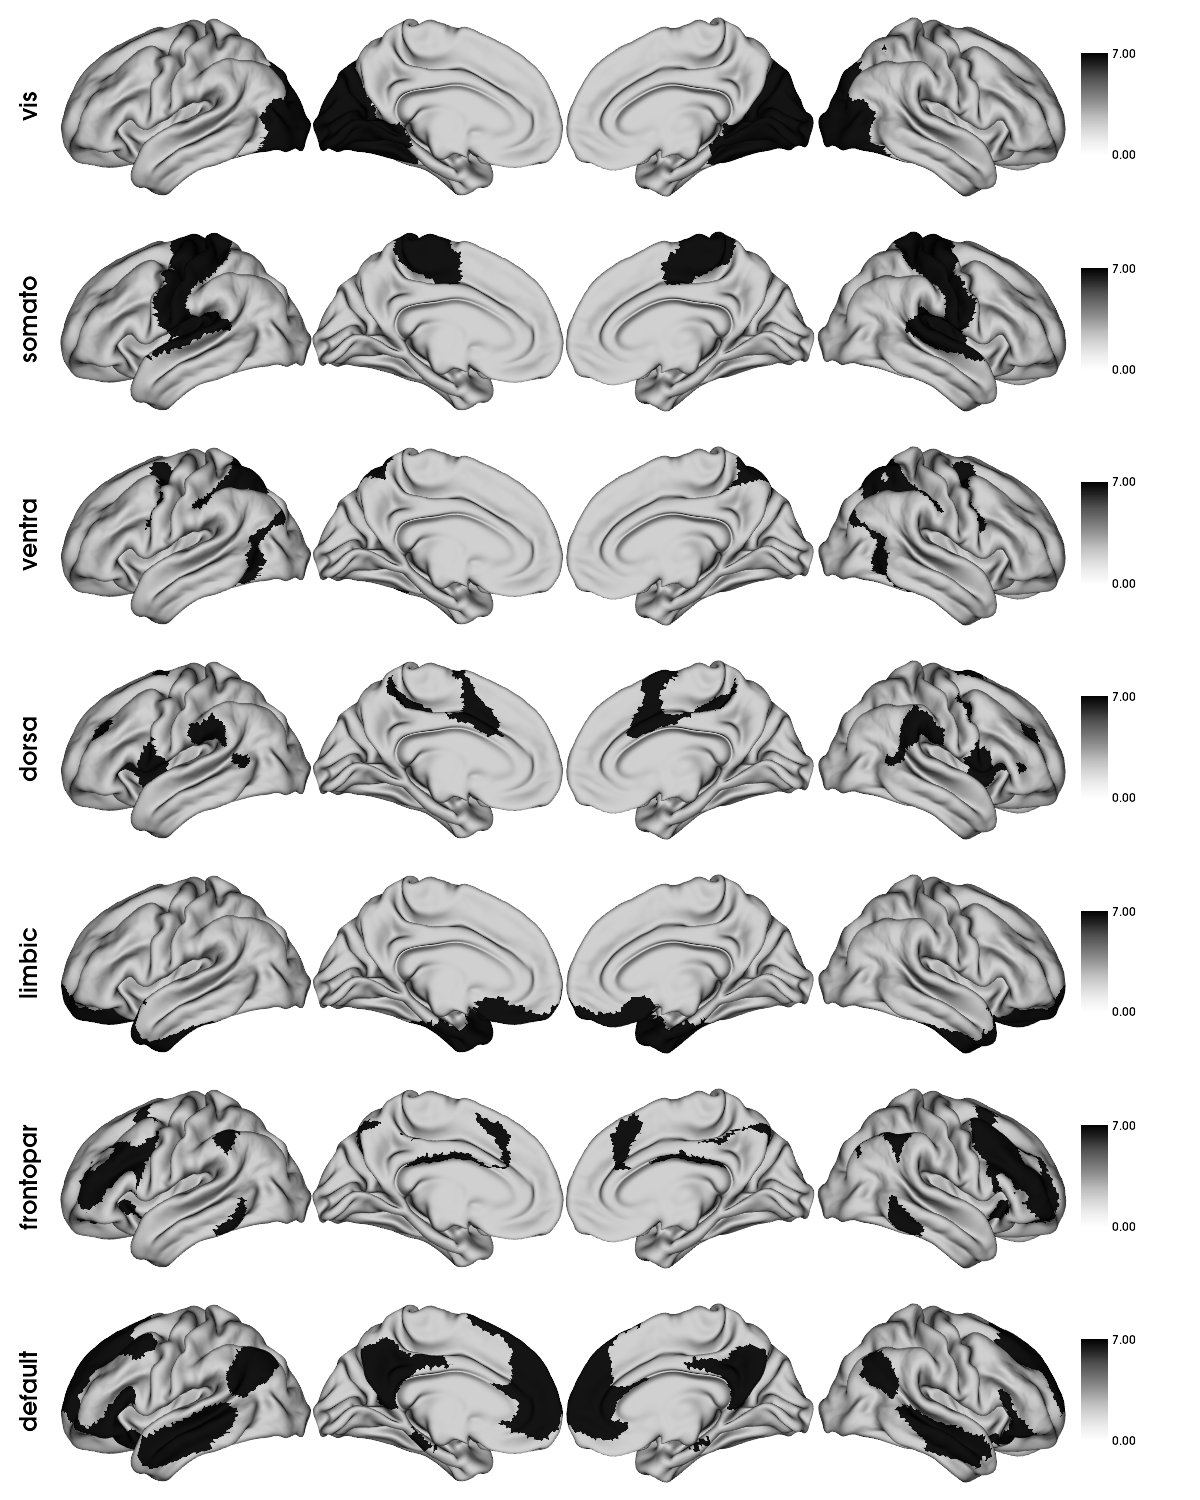

In [40]:
#get the Yeo parcellations
from nibabel import gifti
ParcelDir='/data/mica1/03_projects/jessica/micasoft/parcellations/fs_LR-conte69/maps/'
YeoLHPath=str(ParcelDir+'lh.Yeo2011_7Networks_N1000.label.gii')
YeoRHPath=str(ParcelDir+'rh.Yeo2011_7Networks_N1000.label.gii')
YeoLH=nib.load(YeoLHPath)
YeoRH=nib.load(YeoRHPath)
tmp = YeoLH.agg_data()
YeoLRH=np.append(tmp,YeoRH.agg_data())
print(YeoLRH.shape)

surf_lh, surf_rh = load_conte69()

#make hemisphere plot of each yeo network
print(YeoLRH)
YeoLRH2=np.append([YeoLRH],[YeoLRH],axis=0)
YeoLRH4=np.append(YeoLRH2,YeoLRH2,axis=0)
YeoLRH6=np.append(YeoLRH4,YeoLRH2,axis=0)
Yeo_network=np.append(YeoLRH6,[YeoLRH],axis=0)
Yeo_network=Yeo_network.astype('float')
print(Yeo_network.shape)
for i in range(7):
    Yeo_network[i][Yeo_network[i][:]!=i+1]=np.nan
print(Yeo_network)
#loading all the colors for each network in case we want to show this.
yeo_colours = np.array([[120/255,18/255,134/255],[70/255,130/255,180/255],[0/255,118/255,14/255],[196/255,58/255,250/255],[220/255,248/255,164/255],[230/255,148/255,34/255],[205/255,62/255,78/255]])
print(yeo_colours.shape)

#isolating each yeo region for plotting purposes
Yeo_network[0][Yeo_network[0][:]==1]=7
Yeo_network[1][Yeo_network[1][:]==2]=7
Yeo_network[2][Yeo_network[2][:]==3]=7
Yeo_network[3][Yeo_network[3][:]==4]=7
Yeo_network[4][Yeo_network[4][:]==5]=7
Yeo_network[5][Yeo_network[5][:]==6]=7
Yeo_network[6][Yeo_network[6][:]==7]=7

plot_hemispheres(surf_lh, surf_rh, array_name=Yeo_network, size=(1200,1500), color_range=(0,7),cmap='Greys', color_bar=True, label_text=['vis','somato','ventra','dorsa','limbic','frontopar','default',],
                 embed_nb=True,interactive=False,nan_color=(0.7, 0.7, 0.7, 1),zoom=1.5, cb__labelTextProperty={"fontSize": 12})

In [41]:
#retrieve z-scored data of correlations of whole amygdala and U1 and U2 values as arrays:PcorrAmyg and Pcorr
gauss=10
thrshhld=25
corr_all_subs=np.zeros((3,10,64984))
for count, i in enumerate([1,4,5,6,7,9,10,12,13]):
    if i<10:
        subject = str('PNC00'+str(i))
    else:
        subject = str('PNC0'+str(i))
    path1=str(outDir1+subject+'_fisherZ_whole_amyg_with_cortex_gs'+str(gauss)+'.txt')
    path2=str(outDir1+subject+'_U1U2_fisherZ_top_bot_'+str(thrshhld)+'_with_cortex_gs'+str(gauss)+'.txt')
    Pcorr=np.loadtxt(path2)
    Pcorr=Pcorr[:2][:]
    PcorrAmyg=np.loadtxt(path1)
    corr_all_subs[0][count][:]=PcorrAmyg
    corr_all_subs[1][count][:]=Pcorr[0][:]
    corr_all_subs[2][count][:]=Pcorr[1][:]

PcorrAmyg=np.average(corr_all_subs[0][:][:],axis=0)
Pcorr[0,:]=np.average(corr_all_subs[1][:][:],axis=0)
Pcorr[1,:]=np.average(corr_all_subs[2][:][:],axis=0)

(64984,)
(2, 64984)


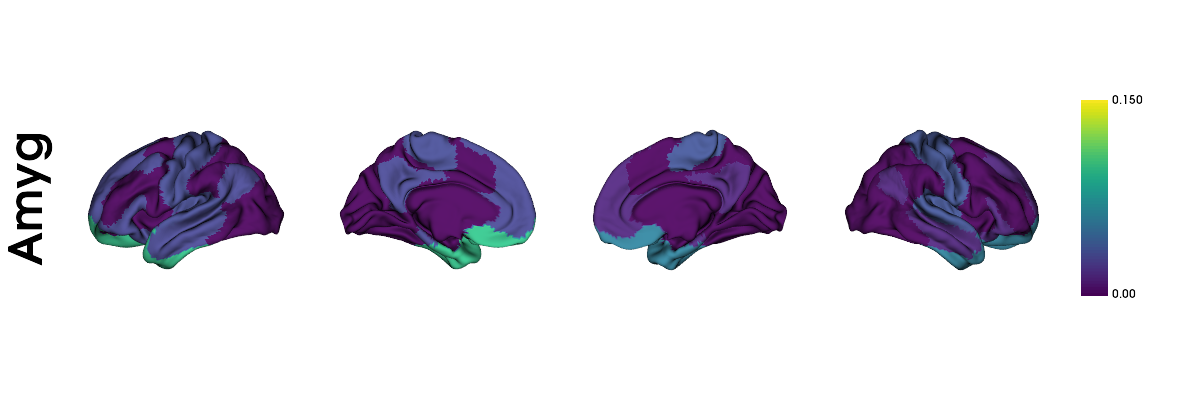

In [42]:
#get the Yeo parcellations
from nibabel import gifti
ParcelDir='/data/mica1/03_projects/jessica/micasoft/parcellations/fs_LR-conte69/maps/'
YeoLHPath=str(ParcelDir+'lh.Yeo2011_7Networks_N1000.label.gii')
YeoRHPath=str(ParcelDir+'rh.Yeo2011_7Networks_N1000.label.gii')
YeoLH=nib.load(YeoLHPath)
YeoRH=nib.load(YeoRHPath)
tmp = YeoLH.agg_data()
YeoLRH=np.append(tmp,YeoRH.agg_data())
print(YeoLRH.shape)

surf_lh, surf_rh = load_conte69()
#show the map of the yeo labels
#plot_hemispheres(surf_lh, surf_rh, array_name=YeoLRH, size=(1200,400), color_range=None, color_bar=True)
print(Pcorr.shape)
#find the average value of correlation for each yeo correlation
YeoAvg=np.zeros((2,64984))
YeoAvgAmyg=np.zeros((64984))
l_avg_par=np.zeros((2,7))
r_avg_par=np.zeros((2,7))
l_avg_amyg=np.zeros((7))
r_avg_amyg=np.zeros((7))
for group in [1,2,3,4,5,6,7]:
    #left hemisphere
    weight = (YeoLRH[:32492]==group).astype(int)
    avg=np.average(Pcorr[:,:32492],axis=1,weights=weight)
    ind=np.where(weight==1)
    for i in ind[0]:
        YeoAvg[:,i]=avg
    l_avg_par[:,group-1]=avg
    #whole amyg
    avgAmyg=np.average(PcorrAmyg[:32492],weights=weight)
    ind=np.where(weight==1)
    for i in ind[0]:
        YeoAvgAmyg[i]=avgAmyg
    l_avg_amyg[group-1]=avgAmyg
    
    #right hemisphere
    weight = (YeoLRH[32492:]==group).astype(int)
    avg=np.average(Pcorr[:,32492:],axis=1,weights=weight)
    ind=np.where(weight==1)
    for i in ind[0]:
        YeoAvg[:,i+32492]=avg
    r_avg_par[:,group-1]=avg
    #whole amyg
    avgAmyg=np.average(PcorrAmyg[32492:],weights=weight)
    ind=np.where(weight==1)
    for i in ind[0]:
        YeoAvgAmyg[i+32492]=avgAmyg
    r_avg_amyg[group-1]=avgAmyg

plot_hemispheres(surf_lh, surf_rh, array_name=YeoAvgAmyg, size=(1200,400), color_range=(0,0.15), color_bar=True, label_text=['Amyg'],interactive=False,embed_nb=True,)

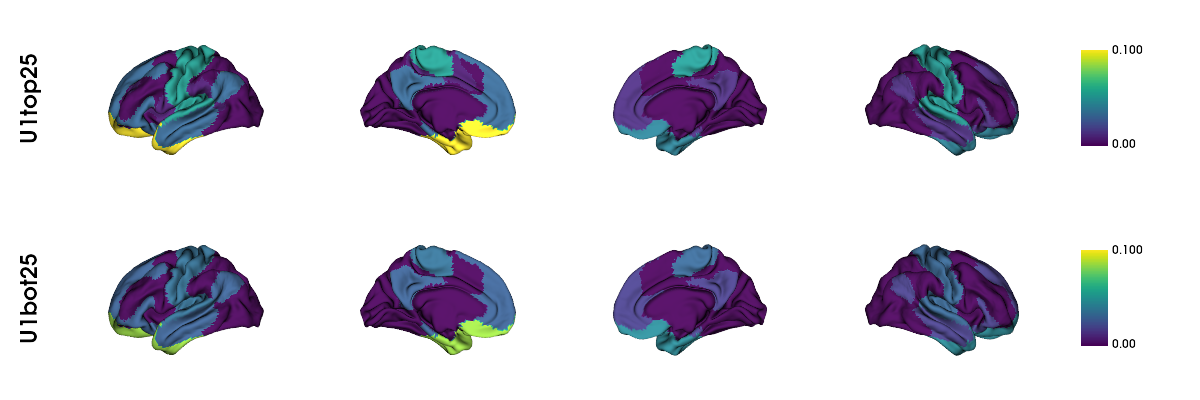

In [44]:
plot_hemispheres(surf_lh, surf_rh, array_name=YeoAvg, size=(1200,400), color_range=(0,0.1), color_bar=True, label_text=['U1top25','U1bot25'],interactive=False,embed_nb=True,)


(2, 8)
(8,)


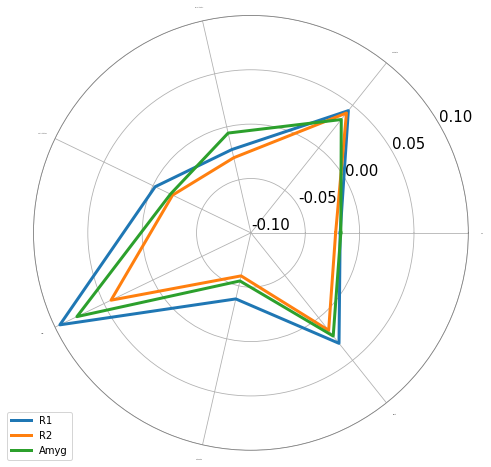

In [49]:
#make Yeo network spider plots for correlation values per each network
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from math import pi

labe=['R1','R2','Amyg']
# obtain df information
categories = ['Visual','Somatomotor','Dorsal Attention','Ventral attention','Limbic','Frontoparietal','Default']
amyg_datan=(np.array(l_avg_amyg) + np.array(r_avg_amyg)) / 2
amyg_datan=np.append(amyg_datan, amyg_datan[:1])
##find some way to append the 2 arrays together
U1_datan=np.append(l_avg_par,r_avg_par,axis=0)

U1_datan=np.append(U1_datan,U1_datan,axis=1)
U1_datan[0]=np.average(U1_datan[:2],axis=0)
U1_datan[1]=np.average(U1_datan[2:],axis=0)
#print(U1_datan.shape)
print(U1_datan[:2,:8].shape)

#amyg_datan=amyg_datan.T
print(amyg_datan.shape)
values=U1_datan[:2,:8]
#values=[U1_datan[0,:8],U1_datan[1,:8],amyg_datan]
#print(values)
#values=U1_datan
#values += values[:1] # repeat the first value to close the circular graph
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# define plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),
                        subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], categories, color='black', size=1)
plt.yticks(np.arange(-0.1, 0.15, 0.05), [ '-0.10','-0.05','0.00','0.05','0.10'], size=15,color='black')
plt.ylim(-0.1, 0.10)
ax.set_rlabel_position(30)

# draw radar-chart:
for i in range(3):
    if i == 2:
        val_c1=amyg_datan
    else:
        val_c1 = values[i,:]
    #val_c1 += val_c1[:1]
    plt.setp(ax.spines.values(), color='grey')
    ax.plot(angles, val_c1, linewidth=3, linestyle='solid',label=labe[i])
    #ax.fill(angles, val_c1, alpha=0.4)
    
# add legent and show plot
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig('yeo_network_radar_plot')